This notebook makes Figure 2(a) from Protheroe & Biermann (1996; https://arxiv.org/pdf/astro-ph/9605119.pdf). There are two stages to the notebook:

1. An annotated guide to the steps in the calculation;
2. Code to reproduce Fig 2(a) exactly;
3. Code to reproduce Fig 2(b) exactly. 

---

In [1]:
import numpy as np
import pylab as pl

from pacholcsyk import *

To start with we can define a few parameters of the galaxy, following PB96: 

- We'll assume a galactic magnetic field strength of 10 $\mu$G.

In [2]:
H_G = 30e-6				# [G] = 30 uGauss  [CGS units]
H_T = H_G*1e-4          # T  [SI units]
N0 = 1e-2				# It doesn't matter what this value is - it'll be normalised out.

pc2cm = 3.086e18
dl = 300.*1000.*pc2cm
dr = 30.*1000.*pc2cm/100. # metres [SI units]
A_m2 = np.pi*dr**2

We'll calculate the spectrum over a range of frequencies from 1 kHz to 12 GHz:

In [3]:
nu = 10**np.arange(3,12,0.1)  # 1 kHz -> 12 GHz

The emissivity [in CGS units] is given by:

$$
\epsilon_{\nu} = \frac{1}{2}c_3 B \sin \theta \int_0^{\infty}{ N(E) F(x) {\rm d}E }
$$

We're going to use the equations from Pacholcsyk. The code for these can be found in the accompanying module pacholcsyk.py.

In [4]:
em_nu = calc_em_synch_AGN(nu,H_G,N0)

integrals.py:15: RuntimeWarning: divide by zero encountered in log
  return quad(lambda x,*args: np.exp(x + np.log(func(np.exp(x),*args))), np.log(a), np.log(b), **kwargs)


Figure 2(a) from Protheroe & Biermann is normalised to ${\rm 1.4\,GHz}$, so let's quickly repeat that at a single frequency:

In [5]:
nu_21cm = np.array([1.4e9])
em_21cm = calc_em_synch_AGN(nu_21cm,H_G,N0)

In [6]:
em_nu2 = eq_3pt50(nu,H_G,N0)
em_nu2_21cm = eq_3pt50(nu_21cm,H_G,N0)

Then we can make the plot:

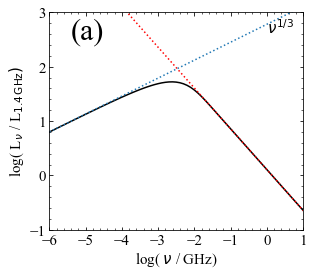

In [7]:
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams

rcParams['font.sans-serif'] = "Times New Roman"
rcParams['font.family'] = "sans-serif"


ax = pl.subplot(111)

pl.plot(np.log10(nu/1e9),np.log10(em_nu/em_21cm),c='black' )
pl.plot(np.log10(nu/1e9),np.log10(em_nu2/em_nu2_21cm),c='red',ls=':')
pl.plot(np.log10(nu/1e9),0.33*np.log10(nu/1e9)+2.78,ls=':')

# make the axes the same as in the paper:
pl.axis([-6,1,-1,3])
pl.xlabel(r"log( $\nu$ / GHz)",size=15)
pl.ylabel(r"log( L$_{\nu}$ / L$_{\rm 1.4\,GHz})$",size=15)
pl.locator_params(axis='x', nbins=8)
pl.locator_params(axis='y', nbins=5)
ax.tick_params(which="both",direction="in",top=True,right=True,labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(1.5)

pl.text(-5.4,2.5,"(a)",size=30)
pl.text(0,2.6,r"$\nu^{1/3}$",size=15)

rcParams['figure.figsize'] = [80, 10]
pl.show()

This is Figure 2(a) from Protheroe & Biermann (1996: https://arxiv.org/pdf/astro-ph/9605119.pdf)

----

Fig 2(b) is made as follows. This requires the full equation of radiative transfer for radio galaxies,

$$
I_{\nu} = S_{\nu}\left( 1 - {\rm e}^{-\tau_{\nu}} \right)
$$

where,

$$
S_{\nu} = \frac{\epsilon_{\nu}}{\kappa_{\nu}}
$$

and

$$
\kappa_{\nu} = -\frac{c^2c_3}{2\nu^2} B \sin \theta \int_0^{\infty}{E^2 \frac{\rm d}{{\rm d}E} \left[\frac{N(E)}{E^2}\right] F(x) {\rm d}E }
$$

(in CGS units).

In [8]:
nu = 10**np.arange(3,12,0.1)  # 1 kHz -> 10 GHz
em_nu = calc_em_synch_AGN(nu,H_G,N0)
kappa_nu = calc_kappa_synch_AGN(nu,H_G,N0)
tau_nu = kappa_nu*dl
i_nu = (em_nu/kappa_nu)*(1 - np.exp(-1.*tau_nu))

In [9]:
L_nu = i_nu*1e-3*4*np.pi*A_m2   # Watts/Hz

In [10]:
L_abs = L_abs_ML(nu, H_T, A_m2)

For this plot, the galaxies have magnetic fields of 10uG:

In [11]:
H_G = 30e-6				# [G] = 10 uGauss  [CGS units]
H_T = H_G*1e-4          # T  [SI units]

We need to add the dashed line given by Eq. 9 in Protheroe & Biermann:

$$
L_{\nu} = \frac{2m_{\rm e}}{3\nu_{\rm g}^{1/2}}4\pi A_{\rm proj}\nu^{5/2}
$$

where

$$
\nu_{\rm g} = \frac{eB}{m_{\rm e}}.
$$


In [12]:
const_e = 1.6e-19   # Joules [SI units]
m_e = 9.1e-31       # kg [SI units]

nu_g = const_e*H_T/m_e  # rad/s
nu_g/= (2*np.pi)  # Hz
L_lim = 2*m_e/(3*nu_g**0.5)*4*np.pi*A_m2*nu**(2.5)   # Watts/Hz  [SI units]

Then we loop through different luminosities. The magnitude of the luminosity is controlled by the normalisation of the CR electron energy spectrum, $N_0$. 

**Note:** This next cell takes a few minutes to run. Definitely long enough to go and make a cup of tea.

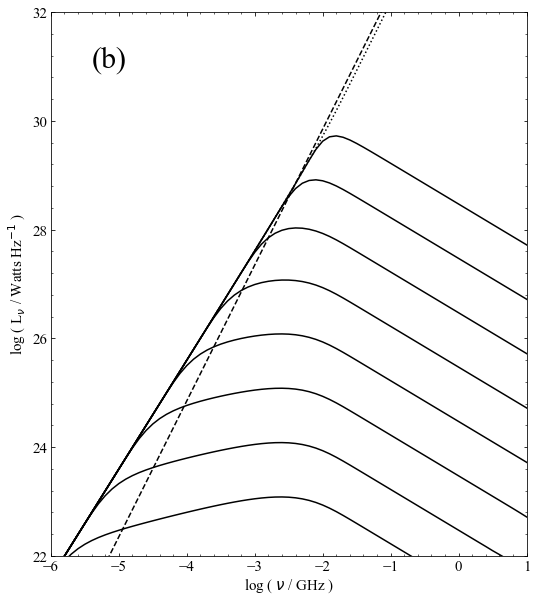

In [14]:
ax = pl.subplot(111)

for N in range(-10,-2):
    N0 = 10.**(N)

    em_nu = calc_em_synch_AGN(nu,H_G,N0)
    kappa_nu = calc_kappa_synch_AGN(nu,H_G,N0)
    tau_nu = kappa_nu*dl
    i_nu = (em_nu/kappa_nu)*(1 - np.exp(-1.*tau_nu))
    L_nu = i_nu*1e-3*4*np.pi*A_m2   # 1e-3 for: erg/s/cm^2/Hz --> Watts/m^2/Hz

    x = np.log10(nu[np.where(L_nu>0.)]/1e9)
    y = np.log10(L_nu[np.where(L_nu>0.)])
    pl.plot(x,y,c='black')
    
em_nu = calc_em_synch_AGN(nu,H_G,N0)
kappa_nu = calc_kappa_synch_AGN(nu,H_G,N0)
pl.plot(np.log10(nu/1e9),np.log10(1e-3*4*np.pi*A_m2*em_nu/kappa_nu),c='black',ls=':')

pl.plot(np.log10(nu/1e9),np.log10(L_lim),c='black',ls='--')
    
pl.axis([-6,1,22,32])
pl.xlabel(r"log ( $\nu$ / GHz )",size=15)
pl.ylabel(r"log ( L$_{\nu}$ / Watts Hz$^{-1}$ )",size=15)
pl.locator_params(axis='x', nbins=8)
pl.locator_params(axis='y', nbins=5)
ax.tick_params(which="both",direction="in",top=True,right=True,labelsize=15)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_aspect(0.8)

pl.text(-5.4,31,"(b)",size=30)

rcParams['figure.figsize'] = [10, 10]
pl.show()